### Load mat data

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
from sklearn.decomposition import FactorAnalysis as factan
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

### Load data

In [2]:
mat_contents = sio.loadmat('/Users/dalin/Documents/My_Research/Dataset/ALM_Svoboda_Lab_Data/Code/TLDS/TempDat/Simultaneous_Spikes.mat')

In [3]:
nDataSet = mat_contents['nDataSet']
params = mat_contents['params']
# nDataSet[0, 0][0].flatten()[0] # sessionIndex
# nDataSet[0, 0][1].flatten() # nUnit
# nDataSet[0, 0][2] # unitROCIndex
# nDataSet[0, 0][3].flatten() # unit_yes_trial_index
# nDataSet[0, 0][4].flatten() # unit_no_trial_index
# nDataSet[0, 0][5] # unit_yes_trial, trial x unit x Time
# nDataSet[0, 0][6] # unit_no_trial, trial x unit x Time
# nDataSet[0, 0][7].flatten() # totTargets
# nDataSet[0, 0][8].flatten() # firstLickTime

### Pick Session #17 for fit

In [4]:
nSession = 17 # matlab index
nSession = nSession - 1
totTargets = nDataSet[0, nSession][7].flatten()
unit_yes_trial = nDataSet[0, nSession][5]
unit_no_trial = nDataSet[0, nSession][6]

In [5]:
from pybasicbayes.util.text import progprint_xrange
from pylds.util import random_rotation
from pyslds.models import DefaultSLDS, HMMSLDS
import numpy.random as npr
from pybasicbayes.distributions import DiagonalRegression, Gaussian, Regression

In [6]:
unit_trial = np.concatenate((unit_yes_trial, unit_no_trial))
numTrial, numUnit, numTime = unit_trial.shape

### initialize the C and D matrix using Factor analysis

In [7]:
factor_unit_trial = unit_trial.transpose([0, 2, 1])
factor_unit_trial = factor_unit_trial.reshape([-1, factor_unit_trial.shape[2]])

In [8]:
np.random.seed(12345678)
# transition
K = 8
yDim = numUnit
xDim = 5
inputDim = 1 # some constants
inputs = np.ones((numTime, inputDim))

In [9]:
estimator = factan(n_components=xDim, tol=0.000001, copy=True, 
                   max_iter=1000, noise_variance_init=None, 
                   svd_method='randomized', iterated_power=3, 
                   random_state=None)

In [10]:
estimator.fit(factor_unit_trial)
C_init = estimator.components_.T
D_init = estimator.mean_.reshape([-1, 1])

### Set up HMMSLDS code
#### DefaultsSLDS using Regression for both latent and observations
#### HMMSLDS can be flexible using DiagonalRegression for either of them

In [11]:
# test_model = DefaultSLDS(K, yDim, xDim, inputDim,
#                          Cs=Cs,
#                          Ds=Ds)


In [12]:
# Initialize init_dynamics_distns
# nu_0 -- nu_0 is a concentration parameter (It has to be at least dim+1. Difference between 1 and 3 was arbitrary)
init_dynamics_distns = [Gaussian(nu_0=xDim+3, 
                                 sigma_0=3.*np.eye(xDim), 
                                 mu_0=np.zeros(xDim), 
                                 kappa_0=0.01) 
                        for _ in range(K)]
# Initialize dynamics distributions
dynamics_distns = [Regression(nu_0=xDim + 1,
                              S_0=xDim * np.eye(xDim),
                              M_0=np.hstack((.99 * np.eye(xDim), np.zeros((xDim, inputDim)))),
                              K_0=xDim * np.eye(xDim + inputDim))
                   for _ in range(K)]

As = [np.eye(xDim) for _ in range(K)]
if inputDim > 0:
    As = [np.hstack((A, np.zeros((xDim, inputDim))))
          for A in As]
for dd, A in zip(dynamics_distns, As):
    dd.A = A

sigma_statess = [np.eye(xDim) for _ in range(K)]
for dd, sigma in zip(dynamics_distns, sigma_statess):
    dd.sigma = sigma

# Initialize emission distributions
# alpha_0, beta_0 -- 
emission_distns = [DiagonalRegression(yDim, xDim + inputDim,
                                      mu_0=None, Sigma_0=None, 
                                      alpha_0=3.0, beta_0=2.0, 
                                      A=np.hstack((C_init.copy(), D_init.copy())), 
                                      sigmasq=None, niter=1)
                   for _ in range(K)]


train_model = HMMSLDS(
    init_dynamics_distns= init_dynamics_distns,
    dynamics_distns= dynamics_distns,
    emission_distns= emission_distns,
    alpha=3., init_state_distn='uniform')

#### Add data to model for each trial

In [13]:
for trial in range(numTrial):
    train_model.add_data(unit_trial[trial].T, inputs=inputs)

#### Fit with Gibbs

In [14]:
print("Initializing with Gibbs")
N_gibbs_samples = 10
def initialize(model):
    model.resample_model()
    return model.log_likelihood()

gibbs_lls = [initialize(train_model) for _ in progprint_xrange(N_gibbs_samples)]

Initializing with Gibbs
..........
   1.36sec avg, 13.61 total



#### Fit with VBEM
This step can be skip??

In [15]:
# Fit with VBEM
print("Fitting with VBEM")
N_vbem_iters = 10
def update(model):
    model.VBEM_step()
    return model.log_likelihood()

train_model._init_mf_from_gibbs()
vbem_lls = [update(train_model) for _ in progprint_xrange(N_vbem_iters)]

Fitting with VBEM
..........
   2.11sec avg, 21.14 total



In [16]:
from matplotlib.gridspec import GridSpec
import seaborn as sns
from hips.plotting.colormaps import gradient_cmap
sns.set_style("white")
sns.set_context("paper")

color_names = ["red", "windows blue", "medium green", "dusty purple", "orange", "amber", "clay", "pink",
               "greyish", "light cyan", "steel blue", "forest green", "pastel purple", "mint", "salmon", "dark brown"]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

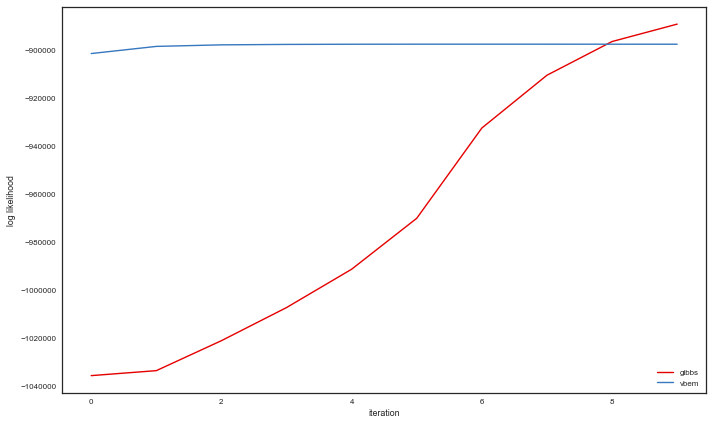

In [17]:
# Plot the log likelihoods
plt.figure(figsize=(10,6))
# plt.plot(np.arange(N_gibbs_samples), gibbs_lls, color=colors[0], label="gibbs")
# plt.plot(np.arange(N_gibbs_samples + 1, N_gibbs_samples + N_vbem_iters), vbem_lls[1:], color=colors[1], label="vbem")
# plt.xlim(0, N_gibbs_samples + N_vbem_iters)
plt.plot(gibbs_lls, color=colors[0], label="gibbs")
plt.plot(np.array(vbem_lls), color=colors[1], label="vbem")
# plt.xlim([950, 1000])
plt.xlabel('iteration')
plt.ylabel('log likelihood')
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig("aux/demo_ll.png")

In [18]:
test_model = train_model

In [19]:
mask = np.ones((numTime, numUnit), dtype=bool)
# leave out the last neuron
mask[:,-1] = False
# add the test data
for trial in range(numTrial):
    test_model.add_data(unit_trial[trial].T, inputs=inputs, mask=mask)
# test_model.add_data(test_trial, inputs=np.ones((numTime, inputDim)), mask=mask)
# get the “states” object associated with the test data
test_states = test_model.states_list.pop()
# fit the discrete and continuous states with the held out neuron

In [20]:
for intr in range(100):
    test_states.resample()
# get the latent states
z_test = test_states.stateseq
x_test = test_states.gaussian_states

7


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# Smooth the data
smoothed_data = test_model.smooth(unit_trial, inputs=inputs)

In [ ]:
fig = plt.figure(figsize=(10,80))
gs = GridSpec(3, 1, height_ratios=[.1, .1, 1.0])
ax = fig.add_subplot(gs[1,0])
timeRange = params['timeSeries'][0][0].flatten()
ax.imshow(test_model.states_list[0].stateseq.reshape(numTrial, numTime), vmin=0, vmax=max(len(colors), test_model.num_states)-1,
          cmap=cmap, interpolation="nearest", extent=[timeRange.min(),timeRange.max(),numTrial,1], aspect='auto')
ax.set_xticks([timeRange.min(), -2.6, -1.2, 0,timeRange.max()])
ax.set_yticks([numTrial, totTargets.sum(),1])
ax.set_xlabel('Time from movement(sec)')
ax.set_ylabel('Trial index')
ax.set_title("Inferred Discrete States")
plt.show()

# ax = fig.add_subplot(gs[2,0])
# plt.plot(y[:,0], color='k', lw=2, label="observed")
# plt.plot(smoothed_data[:,0], color=colors[0], lw=1, label="smoothed")
# plt.xlabel("Time")
# plt.xlim(0, min(T, 500))
# plt.ylabel("Observations")
# plt.legend(loc="upper center", ncol=2)
# plt.tight_layout()
# # d
# # 
# plt.figure()
# from pyhsmm.util.general import rle
# z_rle = rle(z)
# offset = 0
# for k, dur in zip(*z_rle):
#     plt.plot(x[offset:offset+dur,0], x[offset:offset+dur,1], color=colors[k])
#     offset += dur

# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$")
# plt.title("Continuous Latent States")
# plt.show()